# Mineração em Grafos

Luana Lima Freitas - T6

## Video do trabalho
 [Clique aqui para assistir](https://)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import gdown
import re
import sys
import glob
import difflib
import matplotlib.pyplot as plt
from itertools import combinations


## Importando os dados

In [2]:
# Baixando o arquivo
!gdown 1jD_dF0wUoVfndQtUSVJF7LbhXtswj62Q

Downloading...
From: https://drive.google.com/uc?id=1jD_dF0wUoVfndQtUSVJF7LbhXtswj62Q
To: /content/genius.zip
100% 1.11M/1.11M [00:00<00:00, 104MB/s]


In [3]:
# Extraindo o arquivo
!unzip genius.zip

Archive:  genius.zip
   creating: genius/
  inflating: __MACOSX/._genius       
   creating: genius/s05/
  inflating: __MACOSX/genius/._s05   
   creating: genius/s02/
  inflating: __MACOSX/genius/._s02   
   creating: genius/s03/
  inflating: __MACOSX/genius/._s03   
   creating: genius/s04/
  inflating: __MACOSX/genius/._s04   
   creating: genius/s01/
  inflating: __MACOSX/genius/._s01   
   creating: genius/s06/
  inflating: __MACOSX/genius/._s06   
   creating: genius/s08/
  inflating: __MACOSX/genius/._s08   
   creating: genius/s07/
  inflating: __MACOSX/genius/._s07   
  inflating: genius/ref.txt          
  inflating: __MACOSX/genius/._ref.txt  
  inflating: genius/s05/got_s05e09.txt  
  inflating: __MACOSX/genius/s05/._got_s05e09.txt  
  inflating: genius/s05/got_s05e08.txt  
  inflating: __MACOSX/genius/s05/._got_s05e08.txt  
  inflating: genius/s05/got_s05e03.txt  
  inflating: __MACOSX/genius/s05/._got_s05e03.txt  
  inflating: genius/s05/got_s05e02.txt  
  inflating: __MA

### Convertendo o arquivo em DF

In [4]:
caminho = 'genius/*/*.txt'
arquivos = glob.glob(caminho)

got = {}
for arquivo in sorted(arquivos):
    chave = arquivo[-14:-4]

    with open(arquivo, 'r', encoding = 'utf-8') as f:
        texto = f.read()

    got[chave] = texto

In [5]:
colunas = ['TEMPORADA', 'EPSODIO', 'TEXTO']
df = pd.DataFrame(columns=colunas)

for arquivo in sorted(arquivos):
    s = arquivo[-9:-7]
    e = arquivo[-6:-4]

    with open(arquivo, 'r', encoding = 'utf-8') as ep:
      for ln in ep.read().split('\n'):
        if ln != '' and ln is not None:
          nova_linha = {'TEMPORADA': s, 'EPSODIO': e, 'TEXTO': ln}
          df = df.append(nova_linha, ignore_index=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
<ipython-input-5-2f69a85933c6>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(nova_linha, ignore_index=True)
<ipython-input-5-2f69a85933c6>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(nova_linha, ignore_index=True)
<ipython-input-5-2f69a85933c6>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(nova_linha, ignore_index=True)
<ipython-input-5-2f69a85933c6>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(nova_linha, ignore_index=True)
<ipython-input-5-2f69a85933c6>:12: FutureWarning: The frame.append method is 

## Trabalhando o dado

### Encontrando o nome dos personagens

In [32]:
# Defininco se a linha é uma fala
# valid = re.compile(r'(.{1,30}?)(?:(?<!CUT TO)):')
valid = re.compile(r'(.{1,30}?):')
df['FALA'] = df['TEXTO'].apply(lambda x: bool(valid.match(x)))

In [33]:
# separando o nome dos personagens
df['PERSONAGEM'] = df['TEXTO'].str.extract(valid)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('\(.+\)', '', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.upper()
df['PERSONAGEM'] = df['PERSONAGEM'].fillna("-") # Sera que é melhor eu deletar logo essas linhas?
df['PERSONAGEM'] = df['PERSONAGEM'].str.strip()

In [34]:
# Corrigindo falsas falas
df['FALA'] = np.where(df['PERSONAGEM'] == 'INT', False, df['FALA'])
df['FALA'] = np.where(df['PERSONAGEM'] == 'EXT', False, df['FALA'])
df['FALA'] = np.where(df['PERSONAGEM'] == 'CUT TO', False, df['FALA'])
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('INT', '-', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('EXT', '-', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('CUT TO', '-', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace(r'\bALL\b', '-', regex=True)

In [35]:
df_filtro = df[df['PERSONAGEM'].str.contains(r'[0-9]')]
coadjuvante = df_filtro['PERSONAGEM'].unique()

for c in coadjuvante:
  df['PERSONAGEM'] = df['PERSONAGEM'].str.replace(rf'\b{c}\b', '-', regex=True)

In [36]:
coadjuvante = [re.sub(r"[0-9]", "", elemento) for elemento in coadjuvante]
coadjuvante = [re.sub(r"#", "", elemento) for elemento in coadjuvante]
coadjuvante = [re.sub(r" $", "", elemento) for elemento in coadjuvante]
coadjuvante = set(coadjuvante)

for c in coadjuvante:
  df['PERSONAGEM'] = df['PERSONAGEM'].str.replace(rf'^{c}$', '-', regex=True)

### Tratando o nome dos personagens

In [37]:
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('LITTLEFINGER', 'PETYR', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('BAELISH', 'PETYR', regex=True)

df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('EDDARD STARK', 'NED', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('EDDARD', 'NED', regex=True)

df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('SAMWELL TARLY', 'SAM', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('SAMWELL', 'SAM', regex=True)

df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('THE HOUND', 'SANDOR', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('HOUND', 'SANDOR', regex=True)

df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('DANY', 'DAENERYS', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('DAENARYS STORMBORN', 'DAENERYS', regex=True)

df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('HIGH SPARROW', 'SPARROW', regex=True)

df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('GRAND MAESTER PYCELLE', 'PYCELLE', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('MEISTRE', '', regex=True)

In [38]:
# Removendo os principais sobremonos
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('LANNISTER', '', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('STARK', '', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('BARATHEON', '', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('TARGARYEN', '', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('MORMONT', '', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('GREYJOY', '', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('TARLY', '', regex=True)
df['PERSONAGEM'] = df['PERSONAGEM'].str.replace('SNOW', '', regex=True)

df['PERSONAGEM'] = df['PERSONAGEM'].str.strip()

In [39]:
df_filtro = df[df['PERSONAGEM'].str.contains(r'^\w{3,}$')]
personagens = df_filtro['PERSONAGEM'].unique()

def contains_nome(nome):
  for p in personagens:
    if re.match(rf'\b{p}\b', nome) :
      return p
  return nome

df['PERSONAGEM'] = df['PERSONAGEM'].apply(contains_nome)

In [40]:
personagens = df['PERSONAGEM'].value_counts().head(100).index.tolist()

def contains_correspondencia(nome):
  correspondencia = difflib.get_close_matches(nome, personagens, n=1, cutoff=0.8)
  if correspondencia:
      return correspondencia[0]
  else:
      return nome

df['PERSONAGEM'] = df['PERSONAGEM'].apply(contains_correspondencia)

### Gerando a lista dos personagens mais frequentes

In [41]:
counts_personagens = df[df['PERSONAGEM']!='-']['PERSONAGEM'].value_counts()
counts_personagens

TYRION               1862
JON                  1190
DAENERYS             1096
CERSEI               1037
JAIME                 978
                     ... 
STRONG                  1
QUICK                   1
MANDON                  1
BROTHEL KEEPER          1
UNSULLIED CAPTAIN       1
Name: PERSONAGEM, Length: 476, dtype: int64

In [42]:
indice = [i+1 for i in range(len(counts_personagens))]
cod_personagem = {i:j for i,j in enumerate(counts_personagens.index)}
cod_frequencia = {i:j for i,j in enumerate(counts_personagens.values)}

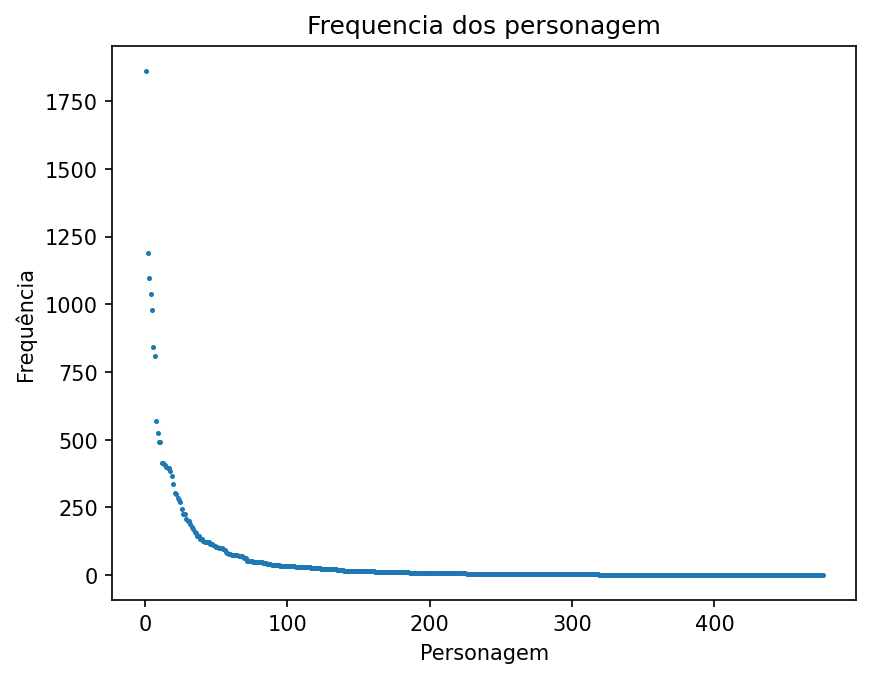

In [43]:
y_values = list(cod_frequencia.values())

plt.figure(dpi=150)
plt.scatter(x=indice, y=y_values, s=2)
plt.title('Frequencia dos personagem')
plt.xlabel('Personagem')
plt.ylabel('Frequência')
plt.show()

In [44]:
valor_acumulado = []
for i in range(len(counts_personagens)) :
    if i == 0:
        valor_acumulado.append(counts_personagens[i])
    else:
        valor_acumulado.append(valor_acumulado[i-1] + counts_personagens[i])

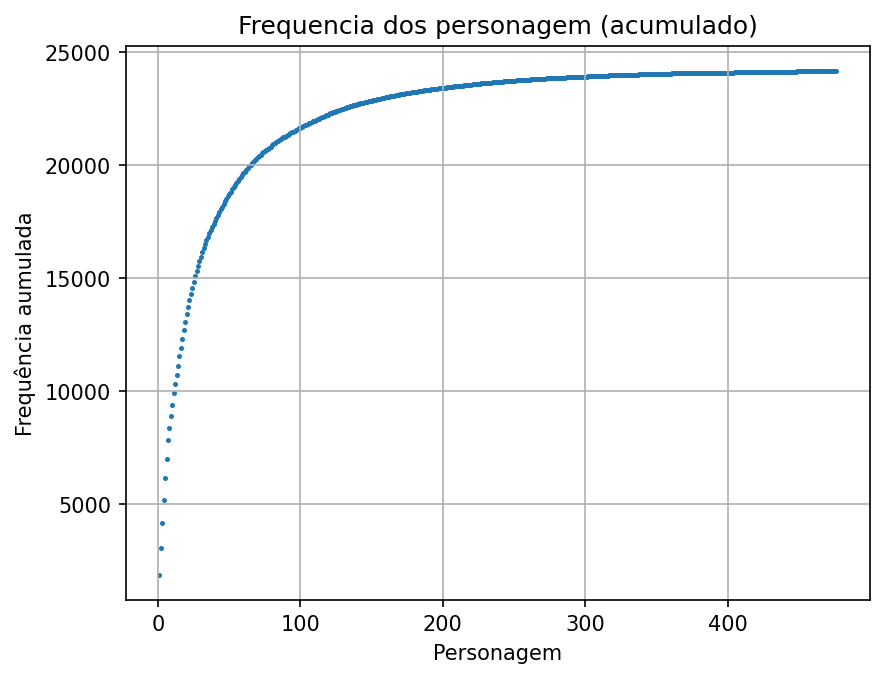

In [45]:
plt.figure(dpi=150)
plt.scatter(x=indice, y=valor_acumulado, s=2)
plt.title('Frequencia dos personagem (acumulado)')
plt.xlabel('Personagem')
plt.ylabel('Frequência aumulada')
plt.grid()
plt.show()

In [46]:
percentual = [ (i/valor_acumulado[-1])*100 for i in valor_acumulado ]

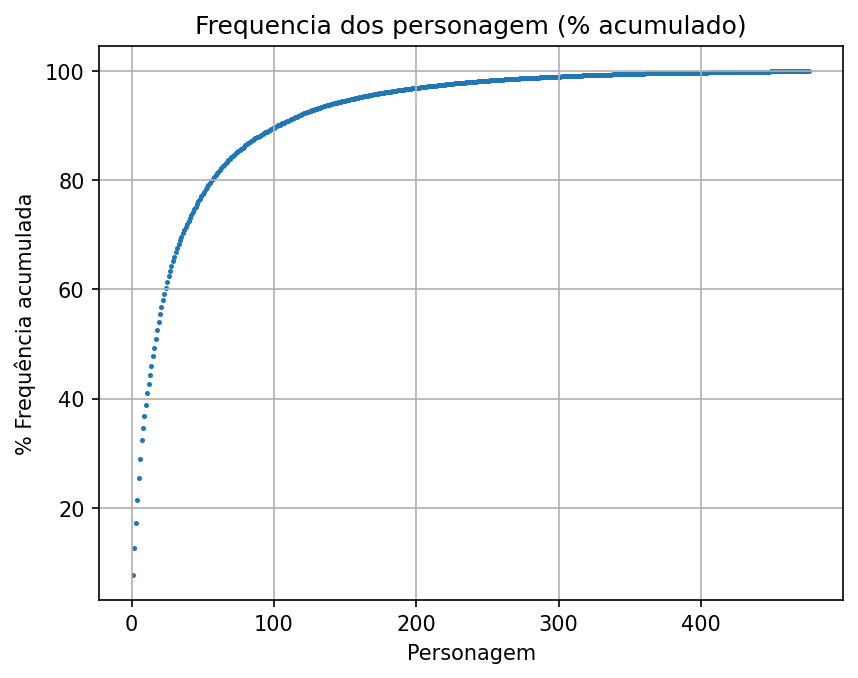

In [47]:
plt.figure(dpi=150)
plt.scatter(x=indice, y=percentual, s=2)
plt.title('Frequencia dos personagem (% acumulado)')
plt.xlabel('Personagem')
plt.ylabel('% Frequência acumulada')
plt.grid()
plt.show()

In [68]:
corte = 90
quantidade = len([i for i in percentual if i < corte])
personagens_principais = list(counts_personagens.index)[:quantidade]
df['PERSONAGEM_PRINCIPAIS'] = df['PERSONAGEM'].isin(personagens_principais)

In [ ]:
# len( personagens_principais)
# personagens_principais

### Separando as cenas

In [49]:
# Separando as cemas
c=1
cenas = []
for i in range(len(df)):
    # c += 1 if df.iloc[i,1] == 0 else 0
    if df.iloc[i,3] == False:
      if df.iloc[i-1,3] == True and i > 0 :
        c += 1
    cenas.append(c)

df['CENA'] = cenas

In [74]:
df_groupby = df.copy()
df_groupby = df_groupby[df_groupby["PERSONAGEM"] != "-"]
df_groupby = df_groupby[df_groupby["PERSONAGEM_PRINCIPAIS"] == True]

In [75]:
df_groupby = df_groupby.groupby('CENA')['PERSONAGEM'].unique().apply(list).reset_index()
df_groupby = df_groupby[df_groupby['PERSONAGEM'].apply(lambda x: len(x) > 1)]
# df_groupby = df_groupby.rename(columns={'PERSONAGEM': 'LIST_PERSONAGEM'})
df_groupby['LIST_OF_EDGES'] = df_groupby['PERSONAGEM'].apply(lambda chars: list(combinations(chars, 2)))

In [76]:
df_groupby.head()

,CENA,PERSONAGEM,LIST_OF_EDGES
2,7,"[SEPTA, SANSA]","[(SEPTA, SANSA)]"
3,8,"[NED, JON, ROBB]","[(NED, JON), (NED, ROBB), (JON, ROBB)]"
6,12,"[CATELYN, NED]","[(CATELYN, NED)]"
7,13,"[CATELYN, NED]","[(CATELYN, NED)]"
9,18,"[NED, JON]","[(NED, JON)]"


## Criando o Grafo

In [77]:
G = nx.Graph()
G.add_nodes_from(personagens_principais)

In [78]:
# Adicionando arestas ao grafo
for edges in df_groupby['LIST_OF_EDGES']:
    G.add_edges_from(edges)

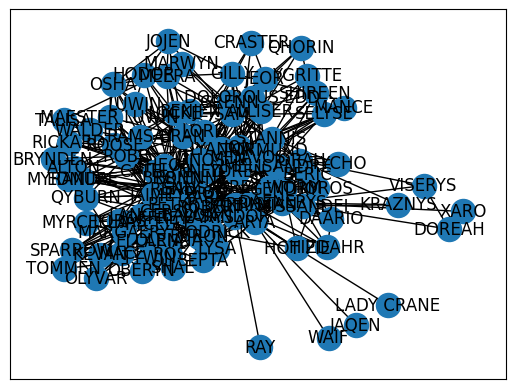

In [79]:
nx.draw_networkx(G, with_labels=True)

## TESTE

In [80]:
print(G.degree)

[('TYRION', 51), ('JON', 44), ('DAENERYS', 26), ('CERSEI', 39), ('JAIME', 40), ('SANSA', 40), ('ARYA', 31), ('SAM', 25), ('DAVOS', 31), ('THEON', 26), ('PETYR', 31), ('VARYS', 25), ('BRAN', 28), ('BRONN', 24), ('BRIENNE', 30), ('JORAH', 19), ('TYWIN', 15), ('SANDOR', 19), ('NED', 30), ('ROBB', 21), ('CATELYN', 31), ('STANNIS', 13), ('MARGAERY', 15), ('RAMSAY', 10), ('JOFFREY', 25), ('MELISANDRE', 16), ('SHAE', 9), ('TORMUND', 18), ('GENDRY', 16), ('OLENNA', 16), ('GILLY', 9), ('MISSANDEI', 12), ('YGRITTE', 5), ('DAARIO', 7), ('PODRICK', 15), ('SPARROW', 8), ('OSHA', 9), ('YARA', 15), ('ROBERT', 16), ('OBERYN', 10), ('ROOSE', 14), ('GREY WORM', 14), ('QYBURN', 8), ('TOMMEN', 5), ('JAQEN', 2), ('PYCELLE', 19), ('TALISA', 8), ('THOROS', 11), ('BARRISTAN', 14), ('BERIC', 11), ('MEERA', 9), ('RENLY', 18), ('EURON', 7), ('LORAS', 14), ('ALLISER', 10), ('SHIREEN', 6), ('GRENN', 9), ('WALDER', 6), ('JOJEN', 6), ('LORD', 15), ('HOT PIE', 5), ('LYSA', 6), ('JEOR', 7), ('ROS', 9), ('LANCEL', 16),

In [31]:
# df_filtrado = df[~df['TEXTO'].str.startswith(df['PERSONAGEM'])]
# df_filtrado = df[df.apply(lambda row: not row['TEXTO'].startswith(row['PERSONAGEM']), axis=1)]
df_filtrado = df[df['PERSONAGEM'] == '- LUWIN']
df_filtrado

,TEMPORADA,EPSODIO,TEXTO,FALA,PERSONAGEM,CENA
134,01,01,MAESTER LUWIN: I’m told he drinks all night.,True,- LUWIN,32
592,01,02,Maester Luwin: It's time we reviewed the accou...,True,- LUWIN,108
594,01,02,Maester Luwin: Poole went south with Lord Star...,True,- LUWIN,108
597,01,02,"Maester Luwin: Very good, my Lord. My Lady.",True,- LUWIN,108
638,01,02,Maester Luwin: The boy was always sure-footed ...,True,- LUWIN,112
645,01,02,"Maester Luwin: What, is there going to be a ba...",True,- LUWIN,112
1206,01,04,Maester Luwin: He has no memory of that day.,True,- LUWIN,168
1213,01,04,Maester Luwin: The boy has lost the use of his...,True,- LUWIN,168
1753,01,05,Maester Luwin: Bran...,True,- LUWIN,212
1755,01,05,Maester Luwin: Lords?,True,- LUWIN,212


In [ ]:
df_teste = df[df['PERSONAGEM'] == '- ELDER']
# df_teste = df[df['TEXTO'].str.contains(r'^Vardis Egen')]
df_teste

,TEMPORADA,EPSODIO,TEXTO,FALA,PERSONAGEM,CENA
23571,05,08,WILDLING ELDER: I’m with Tormund. We stay here...,True,- ELDER,4223


In [ ]:
df['PERSONAGEM'].unique()

array(['-', 'ROYCE', 'WILL', 'GARED', 'JON', 'MORD', 'SANSA', 'NED',
       'ROBB', 'CASSEL', 'CATELYN', 'BRAN', 'THEON', 'JAIME', 'CERSEI',
       'LUWIN', 'ARYA', 'ROBERT', 'TYRION', 'ROS', 'VISERYS', 'DAENERYS',
       'MAID', 'ILLYRIO', 'BENJEN', 'A VOICE', 'JORAH', 'KHAL DROGO',
       'THE HOUND', 'DOREAH', 'IRRI', 'SANDOR CLEGANE', 'ASSASSIN',
       'JHIQUI', 'MYCAH', 'SOLDIER', 'GUARD', 'VARYS', 'LITTLEFINGER',
       'GRAND MAESTER PYCELLE', 'OLD NAN', 'ALLISER THORNE', 'JEOR ',
       'GRENN', 'PYP', 'RAST', 'BARRISTAN SELMY', 'LANCEL ', 'RAKHARO',
       'YOREN', 'RHAKARO', 'MAESTER AEMON', 'SYRIO FOREL', 'SAM',
       'JANOS SLYNT', 'HUGH OF THE VALE', 'TOBHO MOTT', 'GENDRY',
       'MARILLION', 'MASHA HEDDLE', 'BRONN', 'KNIGHT OF HOUSE WHENT',
       'KNIGHT OF HOUSE BRACKEN', 'LORAS TYRELL', 'VARDIS EGEN',
       'STEWARD', 'LYSA ARRYN', 'ROBIN ARRYN', 'MHAEGEN', 'OSHA',
       'WILDLING', 'JORA', 'KNIGHT 1', 'KNIGHT 2', 'KNIGHT 3', 'KNIGHT 4',
       'KNIGHT 5', 'SER VA

In [ ]:
df_filtro = df[df['PERSONAGEM'].str.contains(r'^\w+\s\w+\s\w+\s\w+\s\w+$')]
df_filtro['PERSONAGEM'].unique()

array(['THE OTHERS AT THE TABLE', 'JON WALKS UP TO SAMWELL'], dtype=object)

In [ ]:
G = nx.Graph()
character = df['character'].dropna().unique()
list_of_nodes = character
G.add_nodes_from(list_of_nodes)

In [ ]:
# Adicionando arestas ao grafo
for edges in df_groupby['list_of_edges']:
    G.add_edges_from(edges)

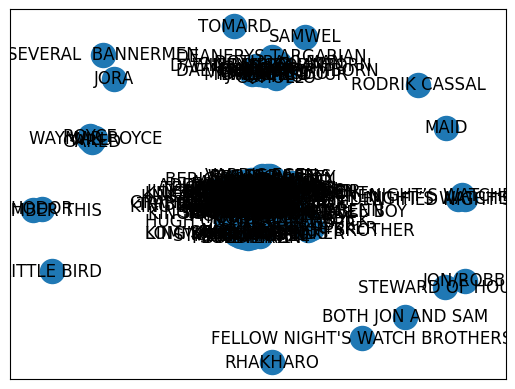

In [ ]:
nx.draw_networkx(G)

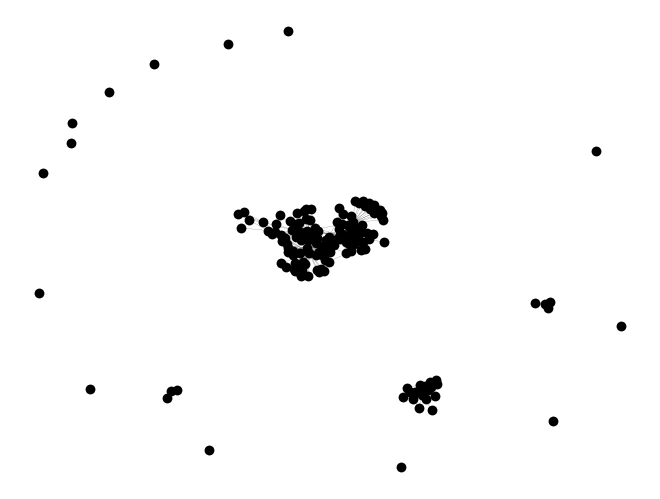

In [ ]:
options = {"node_color": "black", "node_size": 50, "linewidths": 0, "width": 0.1}

pos = nx.spring_layout(G, seed=1969)  # Seed for reproducible layout
nx.draw(G, pos, **options)
plt.show()

KeyError: 'WAYMAR ROYCE'

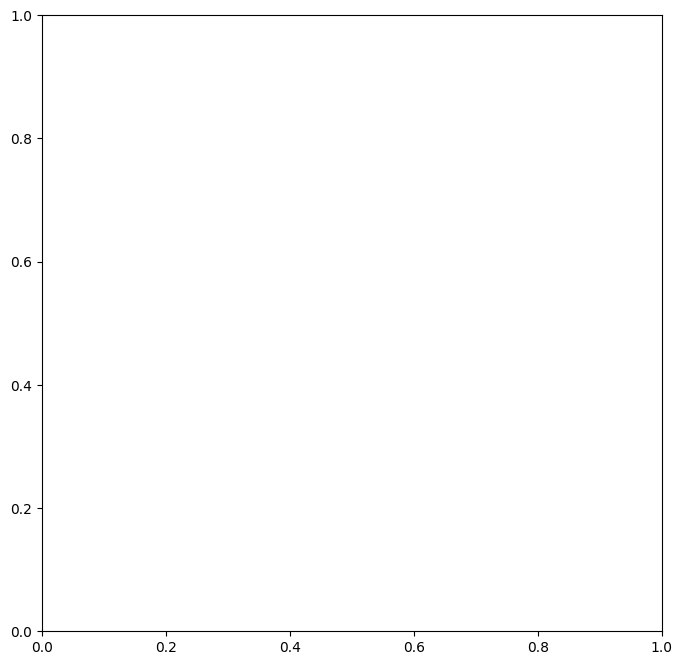

In [ ]:
# pos = nx.get_node_attributes(G, "pos")
# # p = dict(nx.single_source_shortest_path_length(G, ncenter))

# plt.figure(figsize=(8, 8))
# nx.draw_networkx_edges(G, pos, alpha=0.4)
# nx.draw_networkx_nodes(
#     G,
#     pos,
#     # nodelist=list(p.keys()),
#     node_size=80,
#     # node_color=list(p.values()),
#     cmap=plt.cm.Reds_r,
# )

# plt.xlim(-0.05, 1.05)
# plt.ylim(-0.05, 1.05)
# plt.axis("off")
# plt.show()

In [ ]:
import matplotlib.pyplot as plt

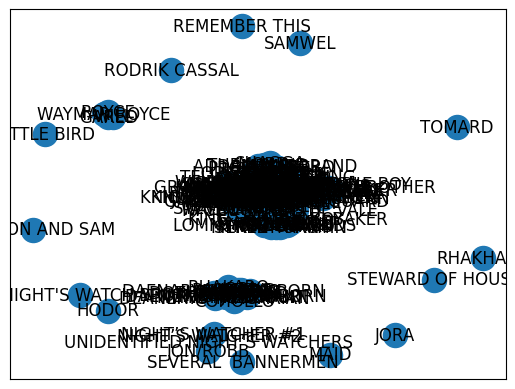

In [ ]:
def plot_network(G):
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G, seed = 42)

    nx.draw_networkx(G, pos)

plot_network(G)

In [ ]:
df.head(3)

In [ ]:
# df.head(200)

In [ ]:
# pd.set_option('display.max_rows', None)
df['character'].value_counts()

In [ ]:
# pd.set_option('display.max_rows', None)
# df['character'].value_counts() #.head(100)
df['character'].unique()

In [ ]:
arquivo = 'got_s01e01.txt'

with open(arquivo, 'r', encoding = 'utf-8') as f:
    texto = f.read()

In [ ]:
df = pd.DataFrame(texto.split('\n'), columns=['texto'])

In [ ]:
df.dropna(inplace=True)
df.drop(df[df['texto']==''].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df['conversa'] = df['texto'].apply(lambda x: 1 if ':' in x else 0)

In [ ]:
c=0
cenas = []
for i in range(len(df)):
    c += 1 if df.iloc[i,1] == 0 else 0
    cenas.append(c)

df['cena'] = cenas

In [ ]:
df['personagem'] = df[df['conversa']==1]['texto'].str.split(':')
df['personagem'] = df['personagem'].apply(lambda x: x[0] if type(x) == type(list()) else '')

In [ ]:
def remover_conteudo_entre_parenteses(texto):
  if isinstance(texto, str):
    texto = re.sub(r'\([^)]*\)', '', texto)
    return texto.strip()
  else:
    return texto

#df['personagem'] = df['personagem'].apply(re.sub(r'\([^)]*\)', '', df['personagem']))
df['personagem'] = df['personagem'].apply(remover_conteudo_entre_parenteses)


In [ ]:
df.info()